# Part 2: Forecasting prices and rents

### Work to do

The purpose of this segment is to create underwriting model in a form familiar to a real estate analyst that helps them understand the expected
returns for properties in this area.

1. Collect a small number of causal datasets that we expect to explain property price and rental income growth. These should include:
    
    For prices & rents:
    - UK National GDP
    - UK National CPI
    - UK Household income growth
    - Local population growth for the postcode (or as close to local data as you can find)


    Costs:

    - UK CPI / London CPI

Use the forecasting library developed by Vitalii (cc'd here) to construct a simple causal forecasting model of the prices, rents and costs. You can work with him
to get access to the underlying model object that gets created so you can perform feature salience analysis etc.

2. For each property size, create a projection of the rent growth and price increase over the next 10 years
3. Create a simple financial model of the investment in the property over the coming 10 years. In Real Estate team, the analysts use excel. Therefore
we will use excelwings or pyexcel to update this initial excel model with the input assumptions that you generate above. Stephen (cc'd) will be able to help
prepare a very simple excel model and answer any modelling questions you have.
4. Use charts to present the results of this analysis and the properties with the highest expected return

1) Have all the data except for LONDON CPI, which I have the national.  For the population growth I have only until 2011. Use data for Brent, whhich contains Killburn (Nw6)

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import utilities
from functools import reduce
import alphamethods

-----------

## DATA LOADING

- [X] GDP (https://countryeconomy.com/gdp/uk) # has not yet been calculated for 2019
- [X] CPI (https://www.inflation.eu/inflation-rates/great-britain/historic-inflation/cpi-inflation-great-britain.aspx)
- [X] House Hold income (https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/bulletins/householddisposableincomeandinequality/financialyearending2019provisional)
- [X] Population grotwh (https://data.london.gov.uk/dataset/historical-census-tables, https://data.brent.gov.uk/dataset/population-change-in-brent---key-facts population change)

### GDP

We have GDP data from 1971 until 2018

In [2]:
gdp = pd.read_csv('./part2_data/GDP.csv').rename(columns={'Year':'year'})
gdp['GDP'] = gdp['GDP'].str.strip('M.$').str.replace(',', '').astype(int)
gdp['Growth'] = gdp['Growth'].str.replace('%','').astype(float)

In [3]:
print(gdp.head())
print('\t\t\t',gdp.shape)

   year      GDP  Growth
0  2018  2828833     1.4
1  2017  2640067     1.9
2  2016  2669107     1.9
3  2015  2897060     2.4
4  2014  3036310     2.6
			 (48, 3)


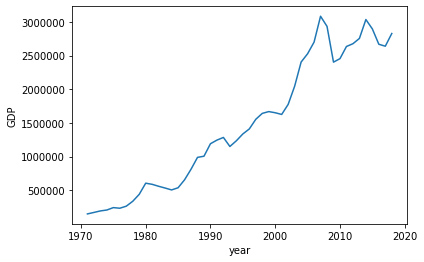

In [4]:
sns.lineplot(x=gdp['year'],y=gdp['GDP'])

### CPI

In [5]:
cpi = pd.read_csv('./part2_data/CPI.csv')
cpi['year'] = cpi['year'].str.split(' ').str[-1].astype(int)
cpi['CPI'] = cpi['CPI'].str.replace('%','').str.strip().astype(float)

In [6]:
print(cpi.head())
print('\t\t\t',cpi.shape)

   year   CPI
0  2019  1.81
1  2018  2.29
2  2017  2.56
3  2016  1.01
4  2015  0.37
			 (64, 2)


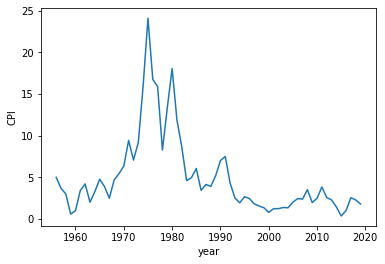

In [7]:
sns.lineplot(x=cpi['year'],y=cpi['CPI'])

###  HouseHold Income

In [8]:
hhi = pd.read_csv('./part2_data/HHI.csv', names = ['year', 'median', 'mean'], skiprows=1)
hhi = hhi.sort_values(by='year', ascending=False)

In [9]:
hhi = hhi.drop('median', 1)
hhi = hhi.rename(columns={'mean':'hhi'})

In [10]:
print(hhi.head())
print('\t\t\t',hhi.shape)

    year    hhi
41  2018  237.2
40  2017  234.4
39  2016  230.1
38  2015  224.9
37  2014  222.2
			 (42, 2)


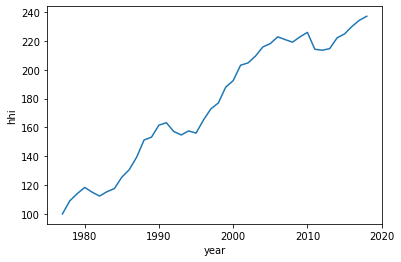

In [11]:
sns.lineplot(x=hhi['year'],y=hhi['hhi'])

### Population Growth

In [12]:
ppg = pd.read_csv('./part2_data/PPG.csv', index_col=0)

ppg = pd.Series(ppg.loc['Brent'])

ppg.index = pd.to_datetime(ppg.index)

In [13]:
# As we have the data every 10 years we can interpolate the points
ppg = ppg.resample('Y').first().interpolate(memoryviewthod='linear')

In [14]:
ppg = pd.DataFrame(ppg).reset_index().rename(columns={'index':'year', 'Brent':'PPG'})
ppg['year'] = ppg['year'].dt.year

In [15]:
print(ppg.head())
print('\t\t\t',ppg.shape)

   year     PPG
0  1801  2000.0
1  1802  2000.0
2  1803  2000.0
3  1804  2000.0
4  1805  2000.0
			 (219, 2)


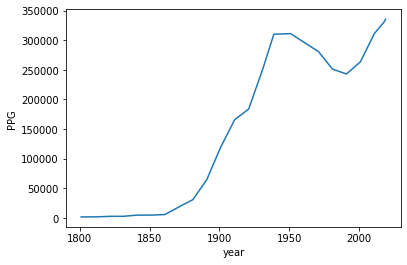

In [16]:
sns.lineplot(data=ppg, x='year', y='PPG')

-------------------

### Data merging

In [17]:
dfs_to_merge = [gdp,cpi,hhi,ppg]

In [18]:
explicative_df = reduce(lambda left, right: pd.merge(left, right, on='year', how='inner'), dfs_to_merge)

In [19]:
explicative_df['date'] = pd.to_datetime(explicative_df['year'],format="%Y")
#explicative_df = explicative_df.drop('year', axis=1)

In [20]:
explicative_df.head()
print(explicative_df.head())
print('\n\t\t Shape:',explicative_df.shape)

   year      GDP  Growth   CPI    hhi            PPG       date
0  2018  2828833     1.4  2.29  237.2  330800.000000 2018-01-01
1  2017  2640067     1.9  2.56  234.4  328002.142857 2017-01-01
2  2016  2669107     1.9  1.01  230.1  325204.285714 2016-01-01
3  2015  2897060     2.4  0.37  224.9  322406.428571 2015-01-01
4  2014  3036310     2.6  1.45  222.2  319608.571429 2014-01-01

		 Shape: (42, 7)


-----------

## Building the predictive models and the forecasting

First we need to extend the explicative variables and so we will do a forecast 10 years into the future for each of them.

To check the code please look into **utilities.py**. It contains the wrappers to easily make the predictions.

In [21]:
import utilities

### Forecasting independent variables

In [22]:
predictions = explicative_df.set_index('date')\
                            .drop('year', axis=1)\
                            .apply(utilities.forecast, freq='A', fh=10, \
                                   endpoint='https://deciml-forecast.com/apiworkers/ts_panel-all',\
                                   column_time='date')\
                            .reset_index()

predictions['date'] = pd.to_datetime(predictions['date'])

Finished forecasting:  GDP
Finished forecasting:  GDP
Finished forecasting:  Growth
Finished forecasting:  CPI
Finished forecasting:  hhi
Finished forecasting:  PPG


In [23]:
fulldf = pd.concat([explicative_df, predictions])

In [24]:
fulldf

,CPI,GDP,Growth,PPG,date,hhi,year
0,2.2900,2.828833e+06,1.4000,330800.000000,2018-01-01,237.2000,2018.0
1,2.5600,2.640067e+06,1.9000,328002.142857,2017-01-01,234.4000,2017.0
2,1.0100,2.669107e+06,1.9000,325204.285714,2016-01-01,230.1000,2016.0
3,0.3700,2.897060e+06,2.4000,322406.428571,2015-01-01,224.9000,2015.0
4,1.4500,3.036310e+06,2.6000,319608.571429,2014-01-01,222.2000,2014.0
5,2.2900,2.755356e+06,2.1000,316810.714286,2013-01-01,214.7000,2013.0
6,2.5800,2.677082e+06,1.5000,314012.857143,2012-01-01,213.6000,2012.0
7,3.8500,2.635799e+06,1.5000,311215.000000,2011-01-01,214.3000,2011.0
8,2.4900,2.455309e+06,1.9000,306440.100000,2010-01-01,226.0000,2010.0
9,1.9700,2.403357e+06,-4.2000,301665.200000,2009-01-01,222.9000,2009.0


In [25]:
fulldf['year'] = fulldf['date'].dt.year

In [26]:
melted_df = fulldf.drop('year', 1).melt(id_vars=['date'])

In [27]:
melted_df

,date,variable,value
0,2018-01-01,CPI,2.2900
1,2017-01-01,CPI,2.5600
2,2016-01-01,CPI,1.0100
3,2015-01-01,CPI,0.3700
4,2014-01-01,CPI,1.4500
...,...,...,...
255,2024-01-01,hhi,251.3126
256,2025-01-01,hhi,253.8021
257,2026-01-01,hhi,256.2780
258,2027-01-01,hhi,258.8192


In [28]:
melted_df['year'] = melted_df['date'].dt.year
melted_df = melted_df.sort_values(by=['variable', 'date'])

In [29]:
melted_df

,date,variable,value,year
41,1977-01-01,CPI,15.8900,1977
40,1978-01-01,CPI,8.2800,1978
39,1979-01-01,CPI,13.3500,1979
38,1980-01-01,CPI,18.0700,1980
37,1981-01-01,CPI,11.8900,1981
...,...,...,...,...
255,2024-01-01,hhi,251.3126,2024
256,2025-01-01,hhi,253.8021,2025
257,2026-01-01,hhi,256.2780,2026
258,2027-01-01,hhi,258.8192,2027


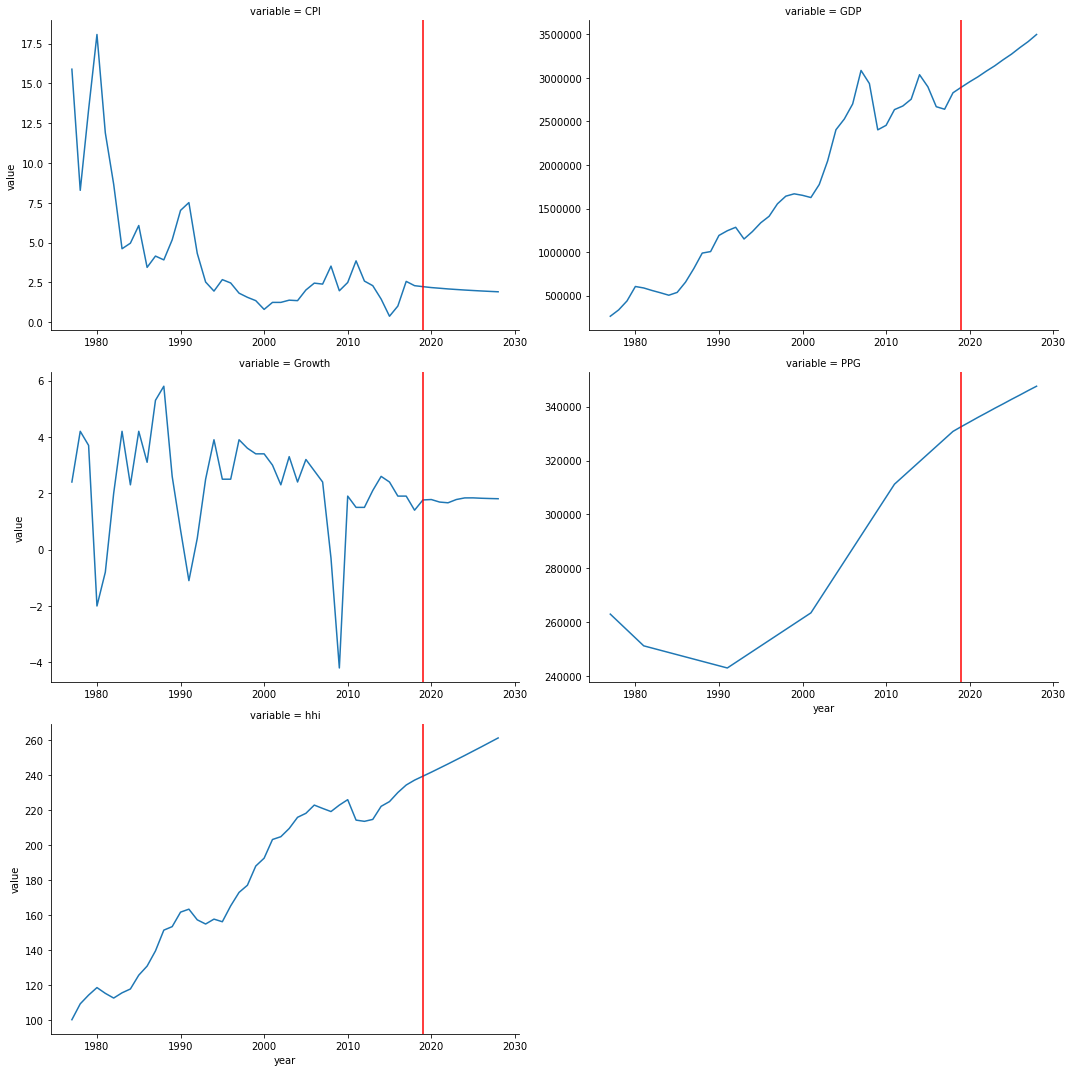

In [30]:
g = sns.FacetGrid(melted_df, col="variable", sharey=False, sharex=False, \
                  aspect=1.5, col_wrap=2, height=5)
g.map(plt.plot, 'year', 'value')

for ax in g.axes:
    ax.axvline(2019, c='red')

plt.show()

### Loading rents and prices

In [31]:
def direction_to_postcode(df, direction_col, dir_pc):
    df['road'] = df[direction_col].str.split(',').str[0].str.strip().str.lower().str.lstrip(' 1234567890')
    df['road2'] = df[direction_col].str.split(',').str[1].str.strip().str.lower().str.lstrip(' 1234567890')
    df = df.replace({'road': dir_pc, 'road2':dir_pc})
    
    df.loc[~df['road'].str.startswith('NW'),'road'] = rents['road2']

    df = df.loc[df['road'].str.startswith('NW'),:]
    
    df['district'] = df['road'].str[-1]
    
    df.drop(['road', 'road2'],1, inplace=True)
    
    return df

In [32]:
# Load sale data
sales = pd.read_csv('nw6_data_price_fut_years_prediction.csv', index_col=0)
sales.loc[sales['beds']>=4,'beds'] = 4
sales['district'] = sales['postcode'].str[4]

In [33]:
# Load postcode data
postcodes = pd.read_csv('./postcode_NW6_to_roads.csv', index_col=0)
postcodes = postcodes.to_dict()['roads']
postcodes = {key:eval(postcodes[key]) for key in postcodes.keys()}
to_postcodes = {road.lower().replace('\'',''):\
                postcode for postcode in postcodes.keys() for road in postcodes[postcode]}

In [34]:
# Load rent data
rents = pd.read_csv('nw6_data_rent_prev_years_prediction.csv', index_col=0)\
          .rename(columns={'price': 'rent'})
rents = direction_to_postcode(rents, 'direction', to_postcodes)

In [35]:
# Merge the data

rents_agg = rents.groupby(['beds', 'year', 'district'])['rent'].mean().reset_index()

full_data =  sales.merge(rents_agg, on=['beds', 'year', 'district'])

full_data['district'] = full_data['district'].astype(int)

full_data['yield'] = 12*100*full_data['rent']/full_data['price']

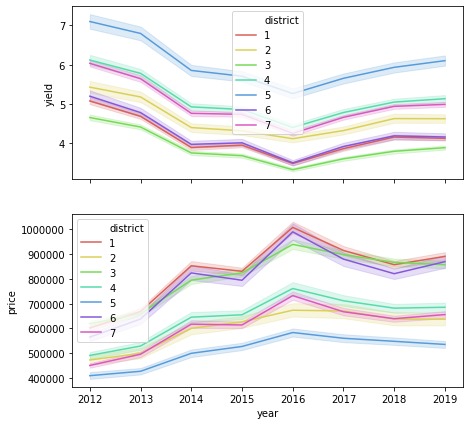

In [36]:
f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

sns.lineplot(y='yield', x='year', data=full_data, hue='district', \
             palette=sns.color_palette("hls", 7), ax=axes[0])

sns.lineplot(y='price', x='year', data=full_data, hue='district', \
             palette=sns.color_palette("hls", 7), ax=axes[1])

plt.show()

In [37]:
def segment_by_2_cols(data, explicative_data,col1, col2, time_column, target_cols):
    
    segmented_data = {}
    
    beds = data[col1].unique()
    districts = data[col2].unique()
    agg_data = data.groupby([col1, col2, time_column])[target_cols].mean()

    for bed in beds:
        
        segmented_data[bed] = {}
        
        for district in districts:
            
            try: # some index combinations might not exist
                segment = agg_data.loc[bed, district]
            except:
                continue
                
            segment = segment.join(explicative_data.set_index(time_column), how='outer')
            train = segment.dropna().reset_index()
            test = segment.loc[max(train[time_column])+1:].reset_index()
                
            segmented_data[bed][district] = {'train':train, 'to_predict':test}
            
    
    return segmented_data

## Forecasting with Alphamethods API

In [38]:
def forecast_ML(ser, freq='A', fh = 10, 
                endpoint='http://apiforecastingservice-env.fwc2bt4dpa.us-east-2.elasticbeanstalk.com/ml_forecasts'):
    """
    Takes a pandas series and makes a call to the forecasting ML API
    to predict future values.
    
    This functions is inteded to be used as a pandas.DataFrame.apply
    method. 
    
    Parameters:
    
        ser (str): a pandas.Series object.
        fh (int): forecasting horizon to make the predictions.
        freq (str): frequency for the predictions. 'A' for Annually
                    'M' for Monthly, etc.
    Returns:
    
        pandas.DataFrame: a pandas Dataframe containing the
                          predictions from the API for the
                          corresponding forecasting horizon.
    
    """
    df = pd.DataFrame(ser).reset_index()
    par = prepare_query(df, freq=freq, fh = fh, column_time='year', 
                        column_data=df.columns[1])
    predictions = make_predictions(par, endpoint)
    predictions = predictions.rename(columns={'ds':'year', 'yhat':df.columns[1]})
    predictions = predictions.set_index('year')
    print('Finished forecasting: ', df.columns[1])
    return predictions[df.columns[1]]

In [220]:
segmented_data = segment_by_2_cols(full_data, fulldf,'beds', 'district', 'year' ,['price', 'rent'])

In [41]:
p = utilities.prepare_query(segmented_data[1][1]['train'], column_data='price', column_time='year', 
                        ind_vars=['CPI', 'PPG'], just_set=True,
                        test_set=segmented_data[1][1]['to_predict'])

In [42]:
def make_predictions(params, url):
    """
    Takes a set of parameters to call the API and retrieve the 
    predictions.
    
    Parameters:
    
        params (str): a JSON containing the relevant parameters.
                      Use prepare_query to get one.
        
        url (str): the URL to use for the request. Check the 
                   the documentation for a list of them.
    Returns:
    
        pandas.DataFrame: a pandas Dataframe containing the
                          predictions from the API for the
                          corresponding forecasting horizon.
    
    """
    
    headers = {'Content-Type': 'application/json'}
    result = requests.post(url, data=params, headers=headers)
    return result
    result = pd.DataFrame(json.loads(result.text))
    
    return result

In [43]:
old_url = 'http://ec2-18-221-69-88.us-east-2.compute.amazonaws.com:8000/ml_forecasts/'
new_url = 'http://ec2-13-59-191-62.us-east-2.compute.amazonaws.com:8000/ml_forecasts/'

In [44]:
p

'{"train": [{"CPI": 2.58, "PPG": 314012.8571428572, "y": 354267.2537957087, "ds": "2012-01-01"}, {"CPI": 2.29, "PPG": 316810.7142857143, "y": 377439.6816938039, "ds": "2013-01-01"}, {"CPI": 1.45, "PPG": 319608.5714285714, "y": 450455.2682046627, "ds": "2014-01-01"}, {"CPI": 0.37, "PPG": 322406.4285714286, "y": 474830.3453207331, "ds": "2015-01-01"}, {"CPI": 1.01, "PPG": 325204.2857142857, "y": 498944.9797342705, "ds": "2016-01-01"}, {"CPI": 2.56, "PPG": 328002.1428571428, "y": 473374.9990286642, "ds": "2017-01-01"}, {"CPI": 2.29, "PPG": 330800.0, "y": 468979.9206139073, "ds": "2018-01-01"}, {"CPI": 2.2292, "PPG": 332582.6307, "y": 478641.6550835632, "ds": "2019-01-01"}], "test": [{"CPI": 2.1717, "PPG": 334294.6784, "y": 1.0, "ds": "2020-01-01"}, {"CPI": 2.1295, "PPG": 336033.6005, "y": 1.0, "ds": "2021-01-01"}, {"CPI": 2.0862, "PPG": 337690.0189, "y": 1.0, "ds": "2022-01-01"}, {"CPI": 2.0506, "PPG": 339388.0029, "y": 1.0, "ds": "2023-01-01"}, {"CPI": 2.0163, "PPG": 341012.1044, "y": 1.

In [45]:
#respond = make_predictions(p, new_url) # doesnt work, do not run (it gets stucked)

to generate a useful test set maybe interpolate the values.

---------------------

## Forecasting Segmented Data with Alphamethods library

In [39]:
import alphamethods
import sklearn
from alphareports.reports import RegressionReport, ForecastingReport

We will start by using the same methods as the API does. 

In [41]:
methods = (
    alphamethods.catboost.CatBoostRegressor, 
    alphamethods.sklearn.VarDecisionTreeRegressor, 
    alphamethods.sklearn.VarGBR, 
    alphamethods.sklearn.AutoSklearnRegressor, 
    alphamethods.h2o.AutoMLRegression
)

Just to try the methods we will work with 1-bedroom houses from district 1.

In [38]:
segmented_data = segment_by_2_cols(full_data, fulldf,'beds', 'district', 'year' ,['price', 'rent'])

In [58]:
train = segmented_data[1][1]['train'].set_index('date').iloc[:-2]
test = segmented_data[1][1]['train'].set_index('date').iloc[-2:]

### Catboost

In [59]:
cb = methods[0](training_data=train,
                target_column='price',
                excluded_columns=['rent', 'year'])
cb.train()

CatBoostError: catboost/private/libs/algo/tensor_search_helpers.cpp:443: Too few sampling units (subsample=0.8, bootstrap_type=MVS): please increase sampling rate or disable sampling

Doesn't work. I believe it's due to it being trained twice (seems it is not allowed by catboos). Will talk with Bohdan.

### VarDecisionTreeRegressor

In [50]:
vdtr = methods[1](training_data=train,
                target_column='price',
                excluded_columns=['rent'])
_, predi = vdtr.train()

In [51]:
predi

,year,price,CPI,GDP,Growth,PPG,hhi,predict_price
date,,,,,,,,
2012-01-01,2012,354267.253796,2.58,2677082.0,1.5,314012.857143,213.6,354267.253796
2013-01-01,2013,377439.681694,2.29,2755356.0,2.1,316810.714286,214.7,377439.681694
2014-01-01,2014,450455.268205,1.45,3036310.0,2.6,319608.571429,222.2,450455.268205
2015-01-01,2015,474830.345321,0.37,2897060.0,2.4,322406.428571,224.9,486887.662528
2016-01-01,2016,498944.979734,1.01,2669107.0,1.9,325204.285714,230.1,486887.662528


Just in the train set we can see that the model didn't generalize well.

In [52]:
vdtr.predict(test)

,year,price,rent,CPI,GDP,Growth,PPG,hhi,predict_price
date,,,,,,,,,
2017-01-01,2017,473374.999029,1571.155211,2.5600,2640067.000,1.9000,328002.142857,234.400,486887.662528
2018-01-01,2018,468979.920614,1638.298596,2.2900,2828833.000,1.4000,330800.000000,237.200,486887.662528
2019-01-01,2019,478641.655084,1651.727273,2.2292,2892935.002,1.7636,332582.630700,239.458,486887.662528


And for the test is the same, predicts the same values.

### VarGBR

In [53]:
vgbr = methods[2](training_data=train,
                  target_column='price',
                  excluded_columns=['rent'])
_vgbr, vgbr_predi = vgbr.train()

In [54]:
vgbr_predi

,year,price,CPI,GDP,Growth,PPG,hhi,predict_price
date,,,,,,,,
2012-01-01,2012,354267.253796,2.58,2677082.0,1.5,314012.857143,213.6,354270.790781
2013-01-01,2013,377439.681694,2.29,2755356.0,2.1,316810.714286,214.7,377441.323971
2014-01-01,2014,450455.268205,1.45,3036310.0,2.6,319608.571429,222.2,450455.275892
2015-01-01,2015,474830.345321,0.37,2897060.0,2.4,322406.428571,224.9,474828.580429
2016-01-01,2016,498944.979734,1.01,2669107.0,1.9,325204.285714,230.1,498941.557676


Seems quite better.

In [55]:
vgbr.predict(test)

,year,price,rent,CPI,GDP,Growth,PPG,hhi,predict_price
date,,,,,,,,,
2017-01-01,2017,473374.999029,1571.155211,2.5600,2640067.000,1.9000,328002.142857,234.400,465886.074762
2018-01-01,2018,468979.920614,1638.298596,2.2900,2828833.000,1.4000,330800.000000,237.200,464814.136208
2019-01-01,2019,478641.655084,1651.727273,2.2292,2892935.002,1.7636,332582.630700,239.458,464906.500580


### AutoSklearn Regressor

In [ ]:
askr = methods[3](training_data=train,
                  target_column='price',
                  excluded_columns=['rent'])
# _askr, askr_predi = askr.train() # Do not run, takes forever.

###  Auto ML Regressor

In [56]:
amlr = methods[4](training_data=train,
                  target_column='price',
                  excluded_columns=['rent'])
_amlrr, amlr_predi = amlr.train()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.5" 2019-10-15; OpenJDK Runtime Environment (build 11.0.5+10-post-Ubuntu-0ubuntu1.118.04); OpenJDK 64-Bit Server VM (build 11.0.5+10-post-Ubuntu-0ubuntu1.118.04, mixed mode, sharing)
  Starting server from /home/angel/anaconda3/envs/mypython3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpx5eq7nj1
  JVM stdout: /tmp/tmpx5eq7nj1/h2o_angel_started_from_python.out
  JVM stderr: /tmp/tmpx5eq7nj1/h2o_angel_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Madrid
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_angel_fwcbkm
H2O cluster total nodes:,1
H2O cluster free memory:,3.881 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"



16:12:57.266: Skipping training of model GBM_2_AutoML_20200110_161247 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_2_AutoML_20200110_161247.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 5.0.

16:12:57.267: Skipping training of model GBM_3_AutoML_20200110_161247 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_3_AutoML_20200110_161247.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 5.0.

16:12:57.268: Skipping training of model GBM_4_AutoML_20200110_161247 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_4_AutoML_20200110_161247.  Details: ERRR on field: _min_rows: The dataset size is 

Basically, not enought samples for h20 method.

As we didn't get any good results with segmented data, we will try to feed all to the model and see how it goes.

## Forecasting non-Segmented Data with Alphamethods library

In [44]:
full_data_ = full_data.groupby(['beds', 'district', 'year'])['price', 'rent', 'yield'].mean().reset_index(level=[0,1])

In [45]:
fulldf_ = fulldf.set_index(['year'])

In [46]:
ns_data = full_data_.join(fulldf_)

In [47]:
ns_data

,beds,district,price,rent,yield,CPI,GDP,Growth,PPG,date,hhi
year,,,,,,,,,,,
2012,1,1,3.542673e+05,1423.439763,5.006177,2.5800,2677082.000,1.5000,314012.857143,2012-01-01,213.600
2012,1,2,3.331991e+05,1420.227642,5.414655,2.5800,2677082.000,1.5000,314012.857143,2012-01-01,213.600
2012,1,3,3.860589e+05,1400.406504,4.511764,2.5800,2677082.000,1.5000,314012.857143,2012-01-01,213.600
2012,1,4,3.218924e+05,1736.504065,6.856838,2.5800,2677082.000,1.5000,314012.857143,2012-01-01,213.600
2012,1,5,2.958313e+05,1369.094851,5.905399,2.5800,2677082.000,1.5000,314012.857143,2012-01-01,213.600
...,...,...,...,...,...,...,...,...,...,...,...
2019,4,1,1.573713e+06,4713.600000,4.006503,2.2292,2892935.002,1.7636,332582.630700,2019-01-01,239.458
2019,4,3,1.448516e+06,3943.000000,3.701216,2.2292,2892935.002,1.7636,332582.630700,2019-01-01,239.458
2019,4,4,1.677249e+06,5015.875000,4.270845,2.2292,2892935.002,1.7636,332582.630700,2019-01-01,239.458


In [48]:
train_ns = ns_data.loc[2012:2016].reset_index().set_index('date')
test_ns = ns_data.loc[2017:].reset_index().set_index('date')

In [49]:
forecast_dict = {}

it = iter(range(0, 10000))
i = next(it)

for bed in range(1,5):
    for district in range(1,8):
        for year in range(2017, 2029):
            forecast_dict[i] = {'year':year, 'beds':bed, 'district':district}
            i = next(it)
            
forecast_dict = pd.DataFrame(forecast_dict).T.set_index('year')

In [50]:
forecast_df = forecast_dict.join(fulldf_)

In [585]:
forecast_df

,beds,district,CPI,GDP,Growth,PPG,date,hhi
year,,,,,,,,
2017,1,1,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000
2017,1,2,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000
2017,1,3,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000
2017,1,4,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000
2017,1,5,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000
...,...,...,...,...,...,...,...,...
2028,4,3,1.9066,3.498263e+06,1.807,347563.640100,2028-01-01,261.3466
2028,4,4,1.9066,3.498263e+06,1.807,347563.640100,2028-01-01,261.3466
2028,4,5,1.9066,3.498263e+06,1.807,347563.640100,2028-01-01,261.3466


### Catboost

In [338]:
train_ns

,year,beds,district,price,rent,yield,CPI,GDP,Growth,PPG,hhi
date,,,,,,,,,,,
2012-01-01,2012,1,1,3.542673e+05,1423.439763,5.006177,2.58,2677082.0,1.5,314012.857143,213.6
2012-01-01,2012,1,2,3.331991e+05,1420.227642,5.414655,2.58,2677082.0,1.5,314012.857143,213.6
2012-01-01,2012,1,3,3.860589e+05,1400.406504,4.511764,2.58,2677082.0,1.5,314012.857143,213.6
2012-01-01,2012,1,4,3.218924e+05,1736.504065,6.856838,2.58,2677082.0,1.5,314012.857143,213.6
2012-01-01,2012,1,5,2.958313e+05,1369.094851,5.905399,2.58,2677082.0,1.5,314012.857143,213.6
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01,2016,4,1,1.953866e+06,4398.645818,3.022082,1.01,2669107.0,1.9,325204.285714,230.1
2016-01-01,2016,4,3,1.791128e+06,3679.535909,2.801500,1.01,2669107.0,1.9,325204.285714,230.1
2016-01-01,2016,4,4,2.067757e+06,4680.723352,3.217885,1.01,2669107.0,1.9,325204.285714,230.1


In [339]:
cb_ns = methods[0](training_data=train_ns,
                    target_column='price',
                    excluded_columns=['rent', 'yield'])
# cb_ns.train() # doesn't work. Same reasons as with the segmented.

### VarDecisionTreeRegressor

In [60]:
vdtr_ns = methods[1](training_data=train_ns.copy(),
                target_column='price',
                excluded_columns=['rent', 'yield'])

vdtr_ns.tuned_parameters[0]['decision_tree_regressor__max_depth'] = range(2,50)

vdtr_ns_model, predi = vdtr_ns.train()

predi_test = vdtr_ns.predict(test_ns.copy())

forecasts_vdtr_ns = vdtr_ns.predict(forecast_df.reset_index())

In [61]:
rr = RegressionReport('Regresion Results', predi_test['price'], predi_test['predict_price'], 
                      features=vdtr_ns.x_train)

In [62]:
rr.metrics()

{'mae': 126385.06305823142,
 'rmse': 222144.51506661088,
 'r2': 0.6733636830412144}

In [63]:
vdtr_ns.column_order

['year', 'beds', 'district', 'CPI', 'GDP', 'Growth', 'PPG', 'hhi']

In [64]:
vdtr_ns_model.estimator[1].feature_importances_

array([1.15120243e-02, 7.41503814e-01, 4.85686828e-02, 2.84961918e-02,
       7.27986524e-04, 4.81020737e-02, 1.29088600e-03, 1.19798341e-01])

In [65]:
forecasts_vdtr_ns

,year,beds,district,CPI,GDP,Growth,PPG,date,hhi,predict_price
0,2017,1,1,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000,4.989450e+05
1,2017,1,2,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000,4.663313e+05
2,2017,1,3,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000,5.413639e+05
3,2017,1,4,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000,4.492924e+05
4,2017,1,5,2.5600,2.640067e+06,1.900,328002.142857,2017-01-01,234.4000,4.164377e+05
...,...,...,...,...,...,...,...,...,...,...
331,2028,4,3,1.9066,3.498263e+06,1.807,347563.640100,2028-01-01,261.3466,1.791128e+06
332,2028,4,4,1.9066,3.498263e+06,1.807,347563.640100,2028-01-01,261.3466,2.067757e+06
333,2028,4,5,1.9066,3.498263e+06,1.807,347563.640100,2028-01-01,261.3466,2.067757e+06
334,2028,4,6,1.9066,3.498263e+06,1.807,347563.640100,2028-01-01,261.3466,2.142683e+06


As it seems to work well we'll create another one for the rent and yield

,year,beds,district,CPI,GDP,Growth,PPG,hhi
0,2017,1,1,2.5600,2.640067e+06,1.900,328002.142857,234.4000
1,2017,1,2,2.5600,2.640067e+06,1.900,328002.142857,234.4000
2,2017,1,3,2.5600,2.640067e+06,1.900,328002.142857,234.4000
3,2017,1,4,2.5600,2.640067e+06,1.900,328002.142857,234.4000
4,2017,1,5,2.5600,2.640067e+06,1.900,328002.142857,234.4000
...,...,...,...,...,...,...,...,...
331,2028,4,3,1.9066,3.498263e+06,1.807,347563.640100,261.3466
332,2028,4,4,1.9066,3.498263e+06,1.807,347563.640100,261.3466
333,2028,4,5,1.9066,3.498263e+06,1.807,347563.640100,261.3466
334,2028,4,6,1.9066,3.498263e+06,1.807,347563.640100,261.3466


In [149]:
vdtr_ns_rent.column_order

['year', 'beds', 'district', 'CPI', 'GDP', 'Growth', 'PPG', 'hhi']

In [163]:
vdtr_ns_rent = methods[1](training_data=train_ns.copy(),
                    target_column='rent',
                    excluded_columns=['price', 'yield'])

vdtr_ns_rent.tuned_parameters[0]['decision_tree_regressor__max_depth'] = range(2,10)

vdtr_ns_rent_model, predi_rent = vdtr_ns_rent.train()

predi_test = vdtr_ns_rent.predict(test_ns.drop(['price', 'yield', 'rent'], axis=1))

forecasts_vdtr_ns_rent = vdtr_ns_rent.predict(forecast_df.reset_index())

In [167]:
rr_rent = RegressionReport('Regresion Results', test_ns['rent'], predi_test['predict_rent'], 
                      features=vdtr_ns_rent.x_train)

In [168]:
rr_rent.metrics()

{'mae': 284.6460446304992,
 'rmse': 320.52311278934144,
 'r2': 0.9039078587899385}

In [173]:
predi_test.set_index(['beds', 'district', 'year']).loc[1,1]

,CPI,GDP,Growth,PPG,hhi,predict_rent
year,,,,,,
2017,2.5600,2640067.000,1.9000,328002.142857,234.400,1458.690041
2018,2.2900,2828833.000,1.4000,330800.000000,237.200,1458.690041
2019,2.2292,2892935.002,1.7636,332582.630700,239.458,1458.690041


In [171]:
forecasts_vdtr_ns_rent.set_index(['beds', 'district', 'year']).loc[1,1]

,CPI,GDP,Growth,PPG,date,hhi,predict_rent
year,,,,,,,
2017,2.5600,2.640067e+06,1.9000,328002.142857,2017-01-01,234.4000,1458.690041
2018,2.2900,2.828833e+06,1.4000,330800.000000,2018-01-01,237.2000,1458.690041
2019,2.2292,2.892935e+06,1.7636,332582.630700,2019-01-01,239.4580,1458.690041
2020,2.1717,2.955234e+06,1.7786,334294.678400,2020-01-01,241.7319,1458.690041
2021,2.1295,3.013130e+06,1.6885,336033.600500,2021-01-01,244.0951,1458.690041
2022,2.0862,3.078179e+06,1.6628,337690.018900,2022-01-01,246.4569,1458.690041
2023,2.0506,3.138753e+06,1.7789,339388.002900,2023-01-01,248.8901,1458.690041
2024,2.0163,3.208045e+06,1.8360,341012.104400,2024-01-01,251.3126,1458.690041
2025,1.9861,3.272544e+06,1.8375,342688.161100,2025-01-01,253.8021,1458.690041


In [160]:
vdtr_ns_yield = methods[1](training_data=train_ns.copy(),
                    target_column='yield',
                    excluded_columns=['price', 'rent'])

vdtr_ns_yield.tuned_parameters[0]['decision_tree_regressor__max_depth'] = range(2,10)

vdtr_ns_yield_model, predi = vdtr_ns_yield.train()

predi_test = vdtr_ns_yield_model.predict(test_ns.drop(['price', 'yield', 'rent'], axis=1))
# Why do I have to manually delete the columns I don't want? I thought the point of specifiying 
# the irrelevant columns was to avoid this sort of operations.

forecasts_vdtr_ns_yield = vdtr_ns_yield.predict(forecast_df.reset_index())

In [101]:
forecasts = forecasts_vdtr_ns_rent.copy()
forecasts['predict_price'] = forecasts_vdtr_ns['predict_price']
forecasts['predict_yield'] = forecasts_vdtr_ns_yield['predict_yield']

In [115]:
forecasts.set_index(['beds', 'district', 'year']).loc[1,1]

,CPI,GDP,Growth,PPG,date,hhi,predict_rent,predict_price,predict_yield
year,,,,,,,,,
2017,2.5600,2.640067e+06,1.9000,328002.142857,2017-01-01,234.4000,1527.51201,498944.979734,4.744385
2018,2.2900,2.828833e+06,1.4000,330800.000000,2018-01-01,237.2000,1527.51201,498944.979734,5.006177
2019,2.2292,2.892935e+06,1.7636,332582.630700,2019-01-01,239.4580,1527.51201,498944.979734,4.744385
2020,2.1717,2.955234e+06,1.7786,334294.678400,2020-01-01,241.7319,1527.51201,498944.979734,4.744385
2021,2.1295,3.013130e+06,1.6885,336033.600500,2021-01-01,244.0951,1527.51201,498944.979734,5.006177
2022,2.0862,3.078179e+06,1.6628,337690.018900,2022-01-01,246.4569,1527.51201,498944.979734,5.006177
2023,2.0506,3.138753e+06,1.7789,339388.002900,2023-01-01,248.8901,1527.51201,498944.979734,4.744385
2024,2.0163,3.208045e+06,1.8360,341012.104400,2024-01-01,251.3126,1527.51201,498944.979734,4.744385
2025,1.9861,3.272544e+06,1.8375,342688.161100,2025-01-01,253.8021,1527.51201,498944.979734,4.744385


Doesn't generalize well

### Var GBR for non-segmented data

In [191]:
vgbr_ns_price = methods[2](training_data=train_ns.copy(),
                      target_column='price',
                      excluded_columns=['rent', 'yield'])
vgbr_ns_model, vgbr_ns_predi = vgbr_ns_price.train()

vgbr_ns_predi_test = vgbr_ns_price.predict(test_ns)

vgbr_ns_predi_test.set_index(['beds', 'district', 'year']).loc[1,1]

forecasts_vgbr_ns_price = vgbr_ns_price.predict(forecast_df.reset_index())

forecasts_vgbr_ns_price.set_index(['beds', 'district', 'year']).loc[1,1]

In [197]:
vgbr_ns_rent = methods[2](training_data=train_ns.copy(),
                      target_column='rent',
                      excluded_columns=['price', 'yield'])

vgbr_ns_rent_model, vgbr_ns_rent_predi = vgbr_ns_rent.train()

vgbr_ns_rent_test = vgbr_ns_rent.predict(test_ns)

vgbr_ns_rent_test.set_index(['beds', 'district', 'year']).loc[1,1]

forecasts_vgbr_ns_rent = vgbr_ns_rent.predict(forecast_df.reset_index())

forecasts_vgbr_ns_rent.set_index(['beds', 'district', 'year']).loc[1,1]

,CPI,GDP,Growth,PPG,date,hhi,predict_rent
year,,,,,,,
2017,2.5600,2.640067e+06,1.9000,328002.142857,2017-01-01,234.4000,1508.044380
2018,2.2900,2.828833e+06,1.4000,330800.000000,2018-01-01,237.2000,1500.504156
2019,2.2292,2.892935e+06,1.7636,332582.630700,2019-01-01,239.4580,1500.504156
2020,2.1717,2.955234e+06,1.7786,334294.678400,2020-01-01,241.7319,1504.518433
2021,2.1295,3.013130e+06,1.6885,336033.600500,2021-01-01,244.0951,1504.518433
2022,2.0862,3.078179e+06,1.6628,337690.018900,2022-01-01,246.4569,1504.518433
2023,2.0506,3.138753e+06,1.7789,339388.002900,2023-01-01,248.8901,1504.518433
2024,2.0163,3.208045e+06,1.8360,341012.104400,2024-01-01,251.3126,1504.523338
2025,1.9861,3.272544e+06,1.8375,342688.161100,2025-01-01,253.8021,1504.523338


In [198]:
vgbr_ns_yield = methods[2](training_data=train_ns.copy(),
                      target_column='yield',
                      excluded_columns=['price', 'rent'])

vgbr_ns_yield_model, vgbr_ns_yield_predi = vgbr_ns_yield.train()

vgbr_ns_yield_test = vgbr_ns_yield.predict(test_ns)

vgbr_ns_yield_test.set_index(['beds', 'district', 'year']).loc[1,1]

forecasts_vgbr_ns_yield = vgbr_ns_yield.predict(forecast_df.reset_index())

forecasts_vgbr_ns_yield.set_index(['beds', 'district', 'year']).loc[1,1]

,CPI,GDP,Growth,PPG,date,hhi,predict_yield
year,,,,,,,
2017,2.5600,2.640067e+06,1.9000,328002.142857,2017-01-01,234.4000,4.264981
2018,2.2900,2.828833e+06,1.4000,330800.000000,2018-01-01,237.2000,4.276089
2019,2.2292,2.892935e+06,1.7636,332582.630700,2019-01-01,239.4580,4.276064
2020,2.1717,2.955234e+06,1.7786,334294.678400,2020-01-01,241.7319,4.276064
2021,2.1295,3.013130e+06,1.6885,336033.600500,2021-01-01,244.0951,4.284414
2022,2.0862,3.078179e+06,1.6628,337690.018900,2022-01-01,246.4569,4.284414
2023,2.0506,3.138753e+06,1.7789,339388.002900,2023-01-01,248.8901,4.284389
2024,2.0163,3.208045e+06,1.8360,341012.104400,2024-01-01,251.3126,4.259803
2025,1.9861,3.272544e+06,1.8375,342688.161100,2025-01-01,253.8021,4.259803


### alpha auto_arima for non-segmented data (buged)

In [203]:
from alphamethods.pmdarima import AlphaPmdarimaTS

In [218]:
auto_arima_rent = AlphaPmdarimaTS(training_data=train_ns.copy(),
                            target_column='rent',
                            excluded_columns=['price', 'yield'])

TypeError: Can't instantiate abstract class AlphaPmdarimaTS with abstract methods do_predict, do_train

### auto_arima for segmented data

In [209]:
from alphamethods.pmdarima import AutoArima

In [235]:
full_data_

,beds,district,price,rent,yield
year,,,,,
2012,1,1,3.542673e+05,1423.439763,5.006177
2013,1,1,3.774397e+05,1435.189856,4.744385
2014,1,1,4.504553e+05,1458.690041,4.042467
2015,1,1,4.748303e+05,1505.690410,3.960406
2016,1,1,4.989450e+05,1527.512010,3.827344
...,...,...,...,...,...
2015,4,7,1.165416e+06,3558.181818,4.013791
2016,4,7,1.703833e+06,3732.727273,2.886259
2017,4,7,1.337611e+06,3870.909091,3.804645


In [238]:
ts_segmented_data = segment_by_2_cols(explicative_data=full_data_.reset_index(), col1='beds', col2='distict', time_column='year',
                                     target_cols=['price', 'rent', 'yield'])

TypeError: segment_by_2_cols() missing 1 required positional argument: 'data'

In [212]:
train_ns

,year,beds,district,price,rent,yield,CPI,GDP,Growth,PPG,hhi
date,,,,,,,,,,,
2012-01-01,2012,1,1,3.542673e+05,1423.439763,5.006177,2.58,2677082.0,1.5,314012.857143,213.6
2012-01-01,2012,1,2,3.331991e+05,1420.227642,5.414655,2.58,2677082.0,1.5,314012.857143,213.6
2012-01-01,2012,1,3,3.860589e+05,1400.406504,4.511764,2.58,2677082.0,1.5,314012.857143,213.6
2012-01-01,2012,1,4,3.218924e+05,1736.504065,6.856838,2.58,2677082.0,1.5,314012.857143,213.6
2012-01-01,2012,1,5,2.958313e+05,1369.094851,5.905399,2.58,2677082.0,1.5,314012.857143,213.6
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01,2016,4,1,1.953866e+06,4398.645818,3.022082,1.01,2669107.0,1.9,325204.285714,230.1
2016-01-01,2016,4,3,1.791128e+06,3679.535909,2.801500,1.01,2669107.0,1.9,325204.285714,230.1
2016-01-01,2016,4,4,2.067757e+06,4680.723352,3.217885,1.01,2669107.0,1.9,325204.285714,230.1


In [225]:
segmented_data[1][1]['to_predict']

,year,price,rent,CPI,GDP,Growth,PPG,date,hhi
0,2020,NaN,NaN,2.1717,2.955234e+06,1.7786,334294.6784,2020-01-01,241.7319
1,2021,NaN,NaN,2.1295,3.013130e+06,1.6885,336033.6005,2021-01-01,244.0951
2,2022,NaN,NaN,2.0862,3.078179e+06,1.6628,337690.0189,2022-01-01,246.4569
3,2023,NaN,NaN,2.0506,3.138753e+06,1.7789,339388.0029,2023-01-01,248.8901
4,2024,NaN,NaN,2.0163,3.208045e+06,1.8360,341012.1044,2024-01-01,251.3126
5,2025,NaN,NaN,1.9861,3.272544e+06,1.8375,342688.1611,2025-01-01,253.8021
6,2026,NaN,NaN,1.9574,3.347329e+06,1.8236,344295.4967,2026-01-01,256.2780
7,2027,NaN,NaN,1.9313,3.416839e+06,1.8145,345962.4545,2027-01-01,258.8192
8,2028,NaN,NaN,1.9066,3.498263e+06,1.8070,347563.6401,2028-01-01,261.3466


In [293]:
model_rent.predict(horizon=10)

,rent
0,1615.549170
1,1577.312304
2,1551.587236
3,1534.279879
4,1522.635804
5,1514.801882
6,1509.531362
7,1505.985452
8,1503.599828
9,1501.994824


In [319]:
results = {}
for bed in segmented_data.keys():
    results[bed] = {}
    for district in segmented_data[bed]:
        results[bed][district] = {}
        
        print(bed, district)
        model_rent = AutoArima(training_data=segmented_data[bed][district]['train'].set_index('year')[['rent']],
                                                            target_column='rent',
                                                            excluded_columns=[])
        
        model_price = AutoArima(training_data=segmented_data[bed][district]['train'].set_index('year')[['price']],
                                                            target_column='price',
                                                            excluded_columns=[])
        
        model_rent.train()
        model_price.train()
        
        segmented_data[bed][district]['model_rent'] = [model_rent]
        
        segmented_data[bed][district]['model_price'] = [model_price]
        
        segmented_data[bed][district]['predictions_rent'] = model_rent.predict(horizon=10)
        segmented_data[bed][district]['predictions_price'] = model_price.predict(horizon=10)
        
        segmented_data[bed][district]['predictions_rent'].index = range(2020, 2020+10)
        segmented_data[bed][district]['predictions_price'].index = range(2020, 2020+10)
        
        results[bed][district] = segmented_data[bed][district]['predictions_rent'].to_dict()
        results[bed][district].update(segmented_data[bed][district]['predictions_price'].to_dict())

3 7
3 3
3 4
3 6
3 1
3 5
3 2
4 7
4 3
4 4
4 6
4 1
2 7
2 3
2 4
2 6
2 1
2 5
1 7
1 3
1 4
1 6
1 1
1 5
1 2


In [320]:
pd.DataFrame(results)[3].loc[7]

{'rent': {2020: 3849.179193357799,
  2021: 3764.716795309826,
  2022: 3652.6329952345714,
  2023: 3542.629704549002,
  2024: 3463.556106470942,
  2025: 3435.845913618059,
  2026: 3466.2413795402863,
  2027: 3546.16514953975,
  2028: 3654.1295965390873,
  2029: 3761.509615351347},
 'price': {2020: 823261.9290203444,
  2021: 806330.8203752412,
  2022: 801800.1509814928,
  2023: 800587.7693480322,
  2024: 800263.3428455862,
  2025: 800176.5281392393,
  2026: 800153.29701237,
  2027: 800147.0804935527,
  2028: 800145.4169881006,
  2029: 800144.9718434031}}

In [324]:
pd.DataFrame(results)

,3,4,2,1
7,"{'rent': {2020: 3849.179193357799, 2021: 3764....","{'rent': {2020: 4034.809201229267, 2021: 4018....","{'rent': {2020: 2134.1174455346636, 2021: 2108...","{'rent': {2020: 1592.4000075358547, 2021: 1585..."
3,"{'rent': {2020: 3014.199176690405, 2021: 2948....","{'rent': {2020: 3977.3125761726396, 2021: 3961...","{'rent': {2020: 2399.507847583723, 2021: 2364....","{'rent': {2020: 1615.8566816684165, 2021: 1615..."
4,"{'rent': {2020: 2827.2786919060673, 2021: 2765...","{'rent': {2020: 5059.525035281586, 2021: 5038....","{'rent': {2020: 2401.6302509387606, 2021: 2375...","{'rent': {2020: 1997.541146140248, 2021: 1985...."
6,"{'rent': {2020: 2340.64215347688, 2021: 2289.1...","{'rent': {2020: 4699.039990132544, 2021: 4679....","{'rent': {2020: 2159.526756655255, 2021: 2124....","{'rent': {2020: 1603.2568327706845, 2021: 1568..."
1,"{'rent': {2020: 2892.943036539748, 2021: 2829....","{'rent': {2020: 4754.619760529809, 2021: 4735....","{'rent': {2020: 2350.2890208258204, 2021: 2325...","{'rent': {2020: 1636.7710080298857, 2021: 1625..."
5,"{'rent': {2020: 3694.233776459304, 2021: 3613....",NaN,"{'rent': {2020: 2532.546382625587, 2021: 2510....","{'rent': {2020: 1572.1855224700578, 2021: 1557..."
2,"{'rent': {2020: 3139.325357418931, 2021: 3070....",NaN,NaN,"{'rent': {2020: 1615.5491698122748, 2021: 1577..."


In [328]:
pd.DataFrame.from_dict?

In [382]:
rent_results = pd.DataFrame.from_dict({(i,j,k): results[i][j][k]
                                       for i in results.keys() 
                                       for j in results[i].keys()
                                       for k in results[i][j].keys() if k=='rent'},
                                   orient='columns').droplevel(2, axis=1).T

price_results = pd.DataFrame.from_dict({(i,j,k): results[i][j][k]
                                       for i in results.keys() 
                                       for j in results[i].keys()
                                       for k in results[i][j].keys() if k=='price'},
                                   orient='columns').droplevel(2, axis=1).T

yield_results = rent_results*12*100/price_results

In [383]:
yield_results = yield_results.reset_index().rename(columns={'level_0':'beds', 'level_1':'district'})

In [384]:
yield_results = yield_results.melt(id_vars=['beds', 'district'], var_name='year', value_name='yield')

In [385]:
yield_results['beds'] = yield_results['beds'].astype('category')
yield_results['district'] = yield_results['district'].astype('category')

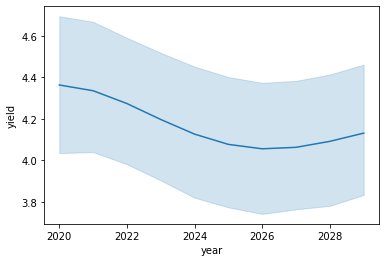

In [386]:
sns.lineplot(data=yield_results, x='year', y='yield')
plt.show()

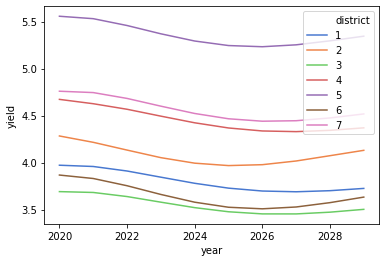

In [392]:
sns.lineplot(data=yield_results, x='year', y='yield', hue='district', err_style=None, legend='full',
            palette=sns.color_palette("muted")[0:len(yield_results['district'].unique())])
plt.show()

In [393]:
yield_results

,beds,district,year,yield
0,3,7,2020,5.610626
1,3,3,2020,3.108120
2,3,4,2020,3.928660
3,3,6,2020,2.873776
4,3,1,2020,3.406795
...,...,...,...,...
245,1,4,2029,5.439628
246,1,6,2029,4.422377
247,1,1,2029,4.010143
248,1,5,2029,4.557467


In [401]:
past_and_results = pd.concat([full_data_.reset_index(), yield_results])

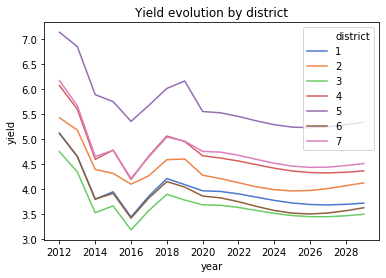

In [477]:
g = sns.lineplot(data=past_and_results, x='year', y='yield', hue='district', err_style=None, legend='full',
            palette=sns.color_palette("muted")[0:len(yield_results['district'].unique())])

plt.title('Yield evolution by district')
g.set(xticks=range(past_and_results['year'].min(),past_and_results['year'].max(),2))
plt.show()

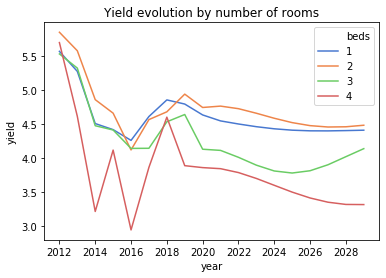

In [478]:
g = sns.lineplot(data=past_and_results, x='year', y='yield', hue='beds', err_style=None, legend='full',
            palette=sns.color_palette("muted")[0:len(yield_results['beds'].unique())])

g.set(xticks=range(past_and_results['year'].min(),past_and_results['year'].max(),2))
plt.title('Yield evolution by number of rooms')
plt.show()

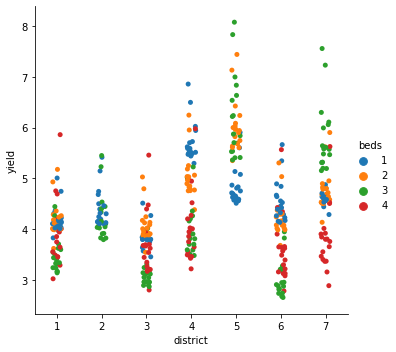

In [415]:
sns.catplot(x="district", y="yield", hue="beds", data=past_and_results)

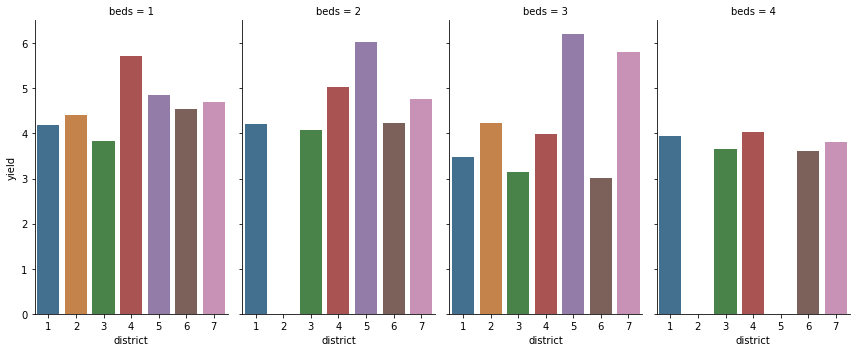

In [425]:
sns.catplot(x="district", y="yield", col="beds",
                data=past_and_results, saturation=.5,
                kind="bar", ci=None, aspect=.6)

In [457]:
tmp_df = past_and_results.groupby(['beds', 'district', 'year'])['yield'].mean().unstack(['district', 'year'])

In [467]:
past_and_results_f = pd.DataFrame(tmp_df.fillna(tmp_df.mean()).stack(['district', 'year'])).rename(columns={0:'yield'}).reset_index()

In [470]:
tmp_df.mean()

district  year
1         2012    5.121866
          2013    4.657558
          2014    3.803758
          2015    3.951398
          2016    3.447882
                    ...   
7         2025    4.465816
          2026    4.439918
          2027    4.445064
          2028    4.474666
          2029    4.517321
Length: 126, dtype: float64

In [468]:
past_and_results_f

,beds,district,year,yield
0,1,1,2012,5.006177
1,1,1,2013,4.744385
2,1,1,2014,4.042467
3,1,1,2015,3.960406
4,1,1,2016,3.827344
...,...,...,...,...
499,4,7,2025,3.552878
500,4,7,2026,3.465305
501,4,7,2027,3.402014
502,4,7,2028,3.368749


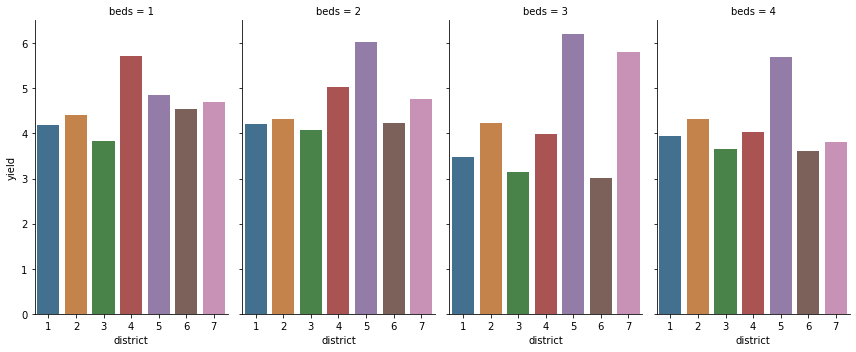

In [469]:
sns.catplot(x="district", y="yield", col="beds",
                data=past_and_results_f, saturation=.5,
                kind="bar", ci=None, aspect=.6)

In [ ]:
df.query('a != -1 or b != -1'

In [500]:
past_and_results_f.query('(beds == 1 or beds == 2) and district==5 and year > 2019')['yield'].mean()

5.225295832452259

In [517]:
yearly_yield = past_and_results_f.query('(beds == 1 or beds == 2) and district==5 and year > 2019')\
                  .groupby(['district', 'year'])\
                  ['yield'].mean()

In [518]:
print(yearly_yield.mean())

5.225295832452259


In [522]:
(yearly_yield/100+1).cumprod()

district  year
5         2020    1.053994
          2021    1.110651
          2022    1.169965
          2023    1.231863
          2024    1.296369
          2025    1.363593
          2026    1.433721
          2027    1.506997
          2028    1.583710
          2029    1.664175
Name: yield, dtype: float64

### Regressive models with segmented data and lags

In [569]:
model_rent = methods[2](train_rent.fillna(0), target_column='rent', excluded_columns=['rent_lag_0', 'date'])
_ = model_rent.train()
model_price = methods[2](train_price.fillna(0), target_column='price', excluded_columns=['price_lag_0', 'date'])
_ = model_rent.train()

In [593]:
test_rent = pd.concat([train_rent, segmented_data[bed][district]['to_predict'][[col for col in segmented_data[bed][district]['to_predict'].columns if 'price' not in col]]])

In [647]:
results_lags = {}
ar_lags = 5
initial_test_year = 2020


for bed in segmented_data.keys():
    results_lags[bed] = {}
    for district in segmented_data[bed]:
        results_lags[bed][district] = {}
        
        print(bed, district)
        
        train_rent = segmented_data[bed][district]['train'][[col for col in segmented_data[bed][district]['train'].columns if 'price' not in col]]
        test_rent = pd.concat([train_rent, segmented_data[bed][district]['to_predict'][[col for col in segmented_data[bed][district]['to_predict'].columns if 'price' not in col]]])

        train_rent = train_rent.set_index('year')
        test_rent = test_rent.set_index('year')
        
        train_price = segmented_data[bed][district]['train'][[col for col in segmented_data[bed][district]['train'].columns if 'rent' not in col]]
        test_price = pd.concat([train_price, segmented_data[bed][district]['to_predict'][[col for col in segmented_data[bed][district]['to_predict'].columns if 'rent' not in col]]])
        
        train_price = train_price.set_index('year')
        test_price = test_price.set_index('year')
        
        for i in range(ar_lags):
            
            test_rent[f"rent_lag_{i}"] = test_rent['rent'].shift(periods=i)
            test_price[f"price_lag_{i}"] = test_price['price'].shift(periods=i)
        
        model_rent = methods[2](train_rent.fillna(0), target_column='rent', excluded_columns=['rent_lag_0', 'date'])
        model_price = methods[2](train_price.fillna(0), target_column='price', excluded_columns=['price_lag_0', 'date'])
        
        _ = model_rent.train()
        _ = model_price.train()
        
        results_lags[bed][district]['rent_model'] = _
        results_lags[bed][district]['price_model'] = _
        
        for year in range(initial_test_year, test_price.index.max()+1):
            
        
            test_rent.loc[year:year]['rent'] = model_rent.predict(test_rent.loc[year:year])['predict_rent']
            test_price.loc[year:year]['price'] = model_price.predict(test_price.loc[year:year])['predict_price']
            
            for i in range(ar_lags):
            
                test_rent[f"rent_lag_{i}"] = test_rent['rent'].shift(periods=i)
                test_price[f"price_lag_{i}"] = test_price['price'].shift(periods=i)
                
        results_lags[bed][district]['rent_predictions'] = test_rent.copy()
        results_lags[bed][district]['price_predictions'] = test_price.copy()
        break
    break

3 7


In [664]:
___ = model_rent.model.estimator[1]

In [665]:
___.feature_importances_

array([0.02270961, 0.02715857, 0.02313946, 0.24443629, 0.17691454,
       0.1182562 , 0.12071168, 0.1629269 , 0.10374674])

In [653]:
model_rent.column_order

['CPI',
 'GDP',
 'Growth',
 'PPG',
 'hhi',
 'rent_lag_1',
 'rent_lag_2',
 'rent_lag_3',
 'rent_lag_4']

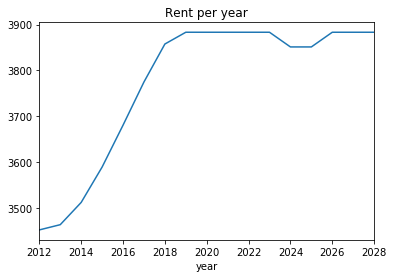

In [667]:
results_lags[3][7]['rent_predictions']['rent'].plot()
plt.title('Rent per year')
plt.show()

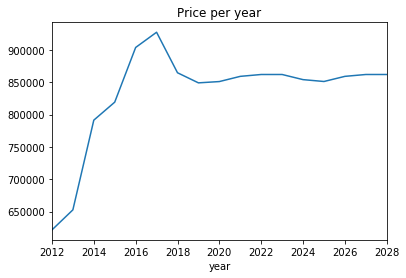

In [668]:
results_lags[3][7]['price_predictions']['price'].plot()
plt.title('Price per year')
plt.show()